<a href="https://colab.research.google.com/github/PaulToronto/IBM---AI-Engineering-Professional-Certificate/blob/main/1_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.3 Classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## 1.3.1 K-Nearest Neighbours

## 1.3.1.1 Introduction to Classification

- A supervised learning approach
- Categorizing some unknown items into a discrete set of categories or **classes**
- The target attribute is a categorical variable
- Classification can be:
    - Binary classification
    - Multiclass classification
- Use cases
    - Which category a customer belongs to
    - Whether a customer switches to another provider/brand
    - Whether a customer responds to a particular advertising campaign
- Some classification algorithms
    - Decision Trees (ID3, C4.5, C5.0)
    - Naive Bayes
    - Linear Discriminant Analysis
    - k-Nearest Neighbour
    - Logistic Regression
    - Neural Networks
    - Support Vector Machines (SVM)

## 1.3.1.2 k-Nearest Neighbours

In [2]:
data_url = 'https://s3-api.us-geo.objectstorage.softlayer.net/'
data_url += 'cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv'

df = pd.read_csv(data_url)
df = df[(df.age < 65) & (df.income < 225)][:50]
df = df[~(df.index == 8)]
df = df[['age', 'income', 'custcat']]
df.reset_index(inplace=True, drop=True)
df.head(8)

,age,income,custcat
0,44,64.0,1
1,33,136.0,4
2,52,116.0,3
3,33,33.0,1
4,30,30.0,3
5,39,78.0,3
6,22,19.0,2
7,35,76.0,4


- We went to predict the `custcat` for a customer whose `age` is 50 and whose income is `166`
- If we choose `k=1`, we can see that the nearest neighbour is in class 4
- If we choose `k=5`, and do a majority vote, we get class 3

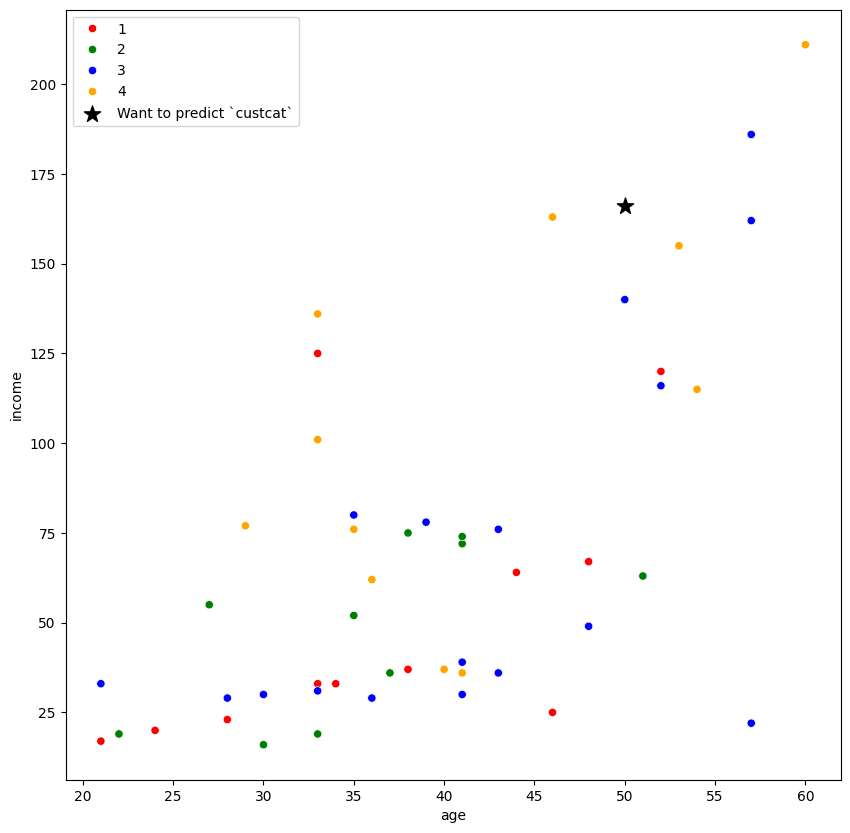

In [3]:
plt.figure(figsize=(10, 10))
sns.scatterplot(df,
                x='age',
                y='income',
                hue='custcat',
                palette=['red', 'green', 'blue', 'orange'])
plt.scatter(50, 166, marker='*', s=150, c='black', label='Want to predict `custcat`')
plt.legend();

### What is k-Nearest Neighbor (KNN)?

- It is a classification algorithm that takes a bunch of labeled points and uses them to learn how to classify other points
- The algorithm classifies cases based on their similarity to other cases
- In KNN, data points that are near each other are said to be neighbors
- Similar cases with the same class labels are near each other
    - Thus, the distance between two cases is a measure of their dissimilarity
- Different ways to calculate the similarity, or conversely, the dissimilarity or distance of two data points
    - Euclidean distance is only one way

### The k-Nearest Neighbors Algorithm

1. Pick a value for `k`
2. Calculate the distance of the unknown case from all cases
3. Search for the `k` observations in the training data that are *nearest* to the unknown data point
4. Predict the response of the unknown data point using the most popular response value from the k-nearest neighbors


### Euclidean Distance

$$
Dis(x_1, x_2) = \sqrt{\sum_{i=0}^{n}\left(x_{1i} - x_{2i}\right)^{2}}
$$

In [4]:
df[:2]

,age,income,custcat
0,44,64.0,1
1,33,136.0,4


$$
\begin{align}
Dis(x_1, x_2) &= \sqrt{\left(44 - 33\right)^2 + \left(64 - 136\right)^{2}} \\
&= \sqrt{11^{2} - (-72)^{2}} \\
&= \sqrt{121 + 5184} \\
&= \sqrt{5305} \\
&= 72.8
\end{align}
$$

In [5]:
dis = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2))

row1 = df.iloc[0, :-1]
row2 = df.iloc[1, :-1]
dis(row1, row2)

72.83543093852057

In [6]:
# suppose the third parameter is education
row1 = np.array([34, 190, 3])
row2 = np.array([30, 200, 8])

dis(row1, row2)

11.874342087037917

### How to choose `k`

- A low value of `k` causes a highly complex model, which might result in overfitting
- A high value of `k`, then the model becomes overly generalized
- How to choose `k`
    - Reserve a part of your data for testing the accuracy of your model
    - Plot `accuracy` vs. `k` for a number of values of `k`

### Computing continuous targets using KNN

- KNN can also be used for regression
- In this situation, instead of a majority vote, use the mean or median to obtain the predicted value

## 1.3.1.3 Evaluation Metrics in Classification

In [7]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y_predicted = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Jaccard Index

- This score is between 0 and 1, with 1 being a perfect match

$$
J\left(y, \widehat{y}\right) = \frac{\lvert y \cap \widehat{y} \rvert}{\lvert y \cup \widehat{y} \rvert} = \frac{\lvert y \cap \widehat{y} \rvert}{\lvert y \rvert + \vert \widehat{y} \rvert - \lvert y \cap \widehat{y} \rvert}
$$

In [8]:
jaccard_score(y_true, y_predicted, average='micro')

0.6

In [9]:
y_intersect_y_hat = (y_true == y_predicted).sum()
len_y = len(y_true)
len_y_hat = len(y_predicted)

print(y_intersect_y_hat, len_y, len_y_hat)

J = y_intersect_y_hat / (len_y + len_y_hat - y_intersect_y_hat)
J

30 40 40


0.6

### Confusion Matrix

In [10]:
print(np.array([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


In [11]:
cm = confusion_matrix(y_true, y_predicted)
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
tp = cm[1, 1]
np.array([[tn, fp],
          [fn, tp]])

array([[ 6,  9],
       [ 1, 24]])

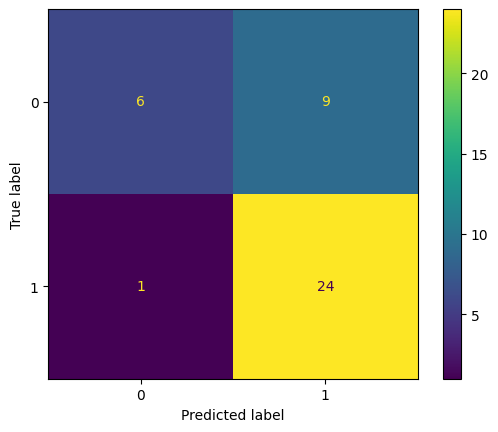

In [12]:
ConfusionMatrixDisplay(cm).plot();

### Accuracy

$$
Accuracy = \frac{TP + TN}{Total}
$$

In [13]:
accuracy_score(y_true, y_predicted), (tp + tn) / (tp + tn + fp + fn)

(0.75, 0.75)

In [14]:
# manual calculation
(y_true == y_predicted).sum() / len(y_true)

0.75

### Precision

$$
Precision = \frac{TP}{TP + FP}
$$

- The accuracy of positive predictions
- Out of all those that wee\re predicted to be positive (5s), what proportion did it get right?

In [15]:
precision_score(y_true, y_predicted), tp / (tp + fp)

(0.7272727272727273, 0.7272727272727273)

### Recall

$$
Recall = \frac{TP}{TP + FN}
$$

- The ratio of positive instances that are correctly detected
- Also called sensitivity or TPR (True Positive Rate)
- Out of all those that were actually positive (5s), how many did it get right?

In [16]:
recall_score(y_true, y_predicted), tp / (tp + fn)

(0.96, 0.96)

### F1 Score

$$
F1 = 2\times\frac{precision \times recall}{precision + recall}
$$

- The harmonic mean of precision and recall
- Ranges from 0 to 1, with 1 being the best score
- The F1 score favours classifiers that have similar precision and recall
    - sometimes you care more about one than the other

In [17]:
f1_score(y_true, y_predicted)

0.8275862068965517

In [18]:
precision = precision_score(y_true, y_predicted)
recall = recall_score(y_true, y_predicted)
2 * (precision * recall) / (precision + recall)

0.8275862068965517

### Classification Report

In [19]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.40      0.55        15
           1       0.73      0.96      0.83        25

    accuracy                           0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



In [20]:
# pos_label is 0
precision_0, recall_0, f1_0 = (
    precision_score(y_true, y_predicted, pos_label=0),
    recall_score(y_true, y_predicted, pos_label=0),
    f1_score(y_true, y_predicted, pos_label=0)
)

precision_0, recall_0, f1_0

(0.8571428571428571, 0.4, 0.5454545454545455)

In [21]:
# pos_label is 1
precision_1, recall_1, f1_1 = (
    precision_score(y_true, y_predicted, pos_label=1),
    recall_score(y_true, y_predicted, pos_label=1),
    f1_score(y_true, y_predicted, pos_label=1)
)

precision_1, recall_1, f1_1

(0.7272727272727273, 0.96, 0.8275862068965517)

### Log Loss

- Sometimes, the output of a classifier is **the probability of a class instead of the label**
    - for example, in logistic regression, the output can be the probability of customer churn
- `log_loss` measures the peformance of a classifier where the predicted output is a probability value between 0 and 1
- the following formula is the calculation for all rows

$$
-\frac{1}{n}\sum(y \, \times \, \log{(\widehat{y})} + (1 - y) \, \times \, \log{(1 - \widehat{y})})
$$

## 1.3.1.4 Lab: KNN

### The Data

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case.

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns.

The target field, called **custcat**, has four possible values that correspond to the four customer groups, as follows:
1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

Our objective is to build a classifier, to predict the class of unknown cases. We will use a specific type of classification called K nearest neighbour.

In [22]:
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/'
data_url += 'IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/'
data_url += 'labs/Module%203/data/teleCust1000t.csv'

df = pd.read_csv(data_url)
df

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3,1
996,1,7,34,0,2,22.0,5,5,0.0,1,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1,4
998,3,70,49,0,18,87.0,2,22,0.0,1,1,3


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [24]:
df['custcat'].value_counts()

,count
custcat,
3,281
1,266
4,236
2,217


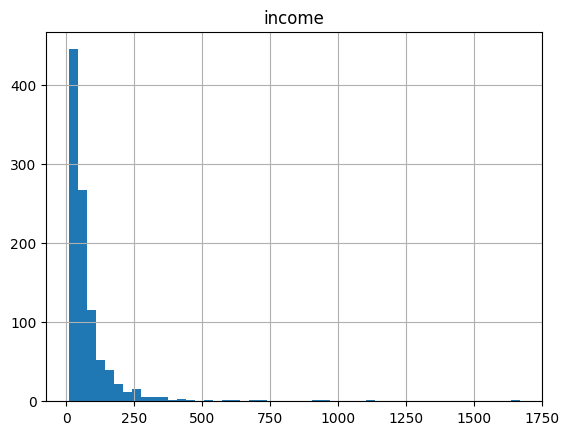

In [25]:
df.hist(column='income', bins=50);

In [26]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

In [27]:
X = df.drop('custcat', axis=1)
X

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
0,2,13,44,1,9,64.0,4,5,0.0,0,2
1,3,11,33,1,7,136.0,5,5,0.0,0,6
2,3,68,52,1,24,116.0,1,29,0.0,1,2
3,2,33,33,0,12,33.0,2,0,0.0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3
996,1,7,34,0,2,22.0,5,5,0.0,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1
998,3,70,49,0,18,87.0,2,22,0.0,1,1


In [28]:
y = df['custcat'].values
y

array([1, 4, 3, 1, 3, 3, 2, 4, 3, 2, 1, 3, 1, 4, 1, 2, 3, 3, 1, 4, 2, 1,
       4, 1, 3, 3, 4, 3, 1, 2, 2, 4, 3, 2, 4, 2, 4, 3, 3, 3, 3, 3, 1, 4,
       3, 2, 2, 4, 1, 3, 1, 2, 4, 1, 1, 1, 2, 1, 3, 2, 3, 4, 1, 4, 4, 1,
       3, 3, 1, 1, 1, 2, 1, 2, 3, 1, 3, 1, 3, 4, 4, 1, 4, 3, 2, 1, 2, 4,
       4, 3, 2, 1, 2, 4, 1, 4, 3, 2, 3, 2, 4, 3, 3, 2, 2, 2, 1, 4, 1, 2,
       2, 2, 1, 2, 3, 1, 3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 4, 2, 2, 4, 3, 1,
       4, 2, 3, 1, 1, 3, 3, 4, 4, 3, 4, 2, 3, 1, 4, 2, 2, 2, 1, 3, 4, 4,
       4, 3, 1, 1, 2, 3, 3, 3, 1, 3, 2, 2, 4, 1, 1, 2, 4, 1, 4, 1, 2, 1,
       3, 4, 4, 1, 4, 1, 2, 2, 2, 1, 1, 2, 3, 3, 1, 4, 2, 3, 4, 1, 1, 3,
       1, 4, 1, 4, 2, 2, 4, 1, 3, 4, 3, 3, 1, 1, 1, 2, 2, 1, 3, 4, 4, 1,
       3, 4, 1, 3, 1, 4, 4, 1, 3, 3, 3, 3, 2, 1, 4, 2, 4, 4, 1, 4, 1, 4,
       3, 2, 1, 3, 2, 1, 1, 2, 1, 4, 2, 2, 4, 3, 2, 1, 4, 4, 4, 1, 3, 2,
       1, 1, 3, 3, 3, 1, 3, 2, 4, 1, 3, 2, 2, 3, 3, 1, 4, 4, 3, 2, 3, 3,
       4, 3, 3, 2, 4, 3, 2, 3, 4, 4, 3, 1, 4, 2, 3,

### Normalize Data

In [29]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-0.02696767, -1.055125  ,  0.18450456, ..., -0.22207644,
        -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243, ..., -0.22207644,
        -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601, ..., -0.22207644,
         0.96655883, -0.23065004],
       ...,
       [ 1.19883553,  1.47425216,  1.37948227, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  1.61477311,  0.58283046, ..., -0.22207644,
         0.96655883, -0.92747794],
       [ 1.19883553,  0.67796676, -0.45281689, ..., -0.22207644,
         0.96655883,  0.46617787]])

### Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 11), (200, 11), (800,), (200,))

### Training and Predicting: `k=4`

In [31]:
k = 4

model4 = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
model4

KNeighborsClassifier(n_neighbors=4)

In [32]:
y_hat_4_train = model4.predict(X_train)
accuracy_score(y_train, y_hat_4_train), (y_train == y_hat_4_train).sum() / len(y_train)

(0.5475, 0.5475)

In [33]:
y_hat_4_test = model4.predict(X_test)
accuracy_score(y_test, y_hat_4_test), (y_test == y_hat_4_test).sum() / len(y_test)

(0.32, 0.32)

### Training and Predicting: `k=6`

In [34]:
k = 6

model6 = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
model6

KNeighborsClassifier(n_neighbors=6)

In [35]:
y_hat_6_train = model6.predict(X_train)
accuracy_score(y_train, y_hat_6_train), (y_train == y_hat_6_train).sum() / len(y_train)

(0.51625, 0.51625)

In [36]:
y_hat_6_test = model4.predict(X_test)
accuracy_score(y_test, y_hat_6_test), (y_test == y_hat_6_test).sum() / len(y_test)

(0.32, 0.32)

### More values for `k`

In [37]:
max_k = 10
ks = range(1, max_k + 1)
accuracy_scores = np.zeros(max_k)
standard_errors= np.zeros(max_k)

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_hat = model.predict(X_test)
    accuracy_scores[k-1] = accuracy_score(y_test, y_hat)
    standard_errors[k-1] = np.std(y_hat == y_test) / np.sqrt(y_hat.shape[0])

accuracy_scores, standard_errors


(array([0.3  , 0.29 , 0.315, 0.32 , 0.315, 0.31 , 0.335, 0.325, 0.34 ,
        0.33 ]),
 array([0.0324037 , 0.03208582, 0.03284623, 0.03298485, 0.03284623,
        0.03270321, 0.03337477, 0.0331191 , 0.03349627, 0.03324906]))

### Plot Accuracy for different values of `k`

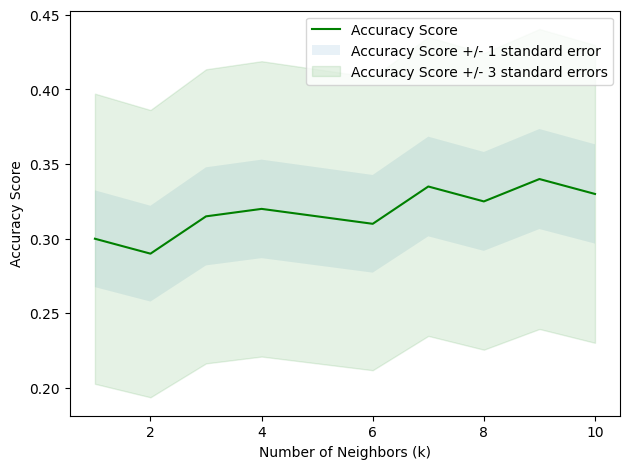

In [38]:
plt.plot(ks, accuracy_scores, 'g', label='Accuracy Score')
plt.fill_between(ks,
                 accuracy_scores - 1 * standard_errors,
                 accuracy_scores + 1 * standard_errors, alpha=0.1,
                 label='Accuracy Score +/- 1 standard error')
plt.fill_between(ks,
                 accuracy_scores - 3 * standard_errors,
                 accuracy_scores + 3 * standard_errors, alpha=0.1, color='green',
                 label='Accuracy Score +/- 3 standard errors')

plt.legend()
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.tight_layout()
plt.show()

In [39]:
print( "The best accuracy was with", accuracy_scores.max(), "with k=", accuracy_scores.argmax()+1)

The best accuracy was with 0.34 with k= 9
